# P3: OpenStreetMap Data Case Study. Dubai and Abu-Dhabi.

### 0. Code Resources

##### 0.1. Code Library

In [15]:
from IPython.core.display import display, HTML

In [16]:
import matplotlib

In [17]:
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

In [28]:
import folium

In [31]:
import geopandas as gpd

ImportError: dlopen(/Users/olgabelitskaya/anaconda/lib/python3.5/site-packages/fiona/ogrext.cpython-35m-darwin.so, 2): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/olgabelitskaya/anaconda/lib/libgdal.20.dylib
  Reason: Incompatible library version: libgdal.20.dylib requires version 41.0.0 or later, but libpng16.16.dylib provides version 39.0.0

In [2]:
from mpl_toolkits.basemap import Basemap

In [3]:
import xml.etree.cElementTree as ET

In [4]:
from collections import defaultdict as dfdict

In [5]:
import numpy as np

In [6]:
import pprint

In [7]:
import urllib

In [8]:
import re

In [9]:
import os

In [10]:
import csv

In [22]:
import cerberus

In [12]:
import json

In [13]:
import codecs

In [14]:
from bson import ObjectId

In [20]:
hide_code = ''
HTML('''<script>
code_show = true; 
function code_display() {
  if (code_show) {
    $('div.input').each(function(id) {
      if (id == 0 || $(this).html().indexOf('hide_code') > -1) {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_display);
</script>
<form action="javascript: code_display()"><input style="opacity: 100" type="submit" 
value="Click to show or to hide code cells"></form>''')

##### For displaying or hiding the code cells the reader of the project can use the button "Click to show or to hide code cells" on the top.

##### 0.2. Useful links

https://wiki.openstreetmap.org/wiki/OSM_XML

http://learnosm.org/en/osm-data/getting-data/#downloading-data-extracts

https://mapzen.com/data/metro-extracts/

http://python-visualization.github.io/folium/quickstart.html

http://geopandas.org/mapping.html

https://borealperspectives.wordpress.com/2016/03/07/plotting-polygon-shapefiles-on-a-matplotlib-basemap-with-geopandas-shapely-and-descartes/

http://maxberggren.se/2015/08/04/basemap/

http://api.mongodb.com/python/current/tutorial.html

https://docs.mongodb.com/manual/reference/operator/query/

##### 0.3. Code for Researching the Imported Files and Creating the Data.

Сode snippets of the courses "Intro to Relational Databases", "Data Wrangling with MongoDB" (udacity.com) have been used here.

In [20]:
hide_code
# Function for counting tags
def count_tags(filename):
    count = dfdict(int)
    for item in ET.iterparse(filename):
        count[item[1].tag] += 1
    return count

In [21]:
hide_code
# Functions for counting users
def get_user(element):
    return

def process_map_users(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if element.tag == 'node' or element.tag == 'way' or element.tag == 'relation':
            users.add(element.attrib['user'])

    return users

In [22]:
hide_code
# Strings containing lower case chars
lower = re.compile(r'^([a-z]|_)*$') 
# Strings with lower case chars and a ':'
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
# Strings with chars that will cause problems as keys. 
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')  

# Function for sorting by key type
def key_type(element, keys):
    if element.tag == "tag":

            if lower.search(element.attrib['k']) != None: 
                keys['lower'] += 1
            elif lower_colon.search(element.attrib['k']) != None:
                keys['lower_colon'] += 1
            elif problemchars.search(element.attrib['k']) != None:
                keys['problemchars'] += 1
            else: 
                keys['other'] += 1

    return keys

# Function for counting keys by type
def process_map_keys(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

In [23]:
hide_code
# Function for counting street addresses
def street_number(file_name):
    count = 0

    for event, elem in ET.iterparse(file_name, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "addr:street":
                    count += 1
    return count

In [24]:
hide_code
# Function for counting zip codes
def zip_codes(filename):
    count = 0
    data = set()

    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "addr:postcode":
                    count += 1
                    data.add( tag.attrib['v'] )
                                     
    return count, data

In [25]:
hide_code
# Functions for auditing zip codes.
expected=[]

def audit_postcode_range(postcode,tag):
    if tag.attrib["v"] not in expected:
        if tag.attrib["v"] not in postcode:
            postcode[tag.attrib["v"]]=1
        else:
            postcode[tag.attrib["v"]]+=1    
            
def is_postcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def process_map_postcodes(filename):
    postcode={}
    osm_file = open(filename, "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postcode(tag):
                    audit_postcode_range(postcode,tag)
    return postcode   

In [26]:
hide_code
# Function for displaying english names
def process_map_names(filename):
    count = 0
    data = set()

    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "name:en":
                    count += 1
                    data.add( tag.attrib['v'] )
                                     
    return count, data 

In [27]:
hide_code
# Function for sorting by place
def place_type(element, places):
    if element.tag == "node":
         for tag in element.iter('tag'):
                if tag.attrib['k'] == 'place':
                    if tag.attrib['v'] == 'city': 
                        places['city'] += 1
                    elif tag.attrib['v'] == 'town':
                        places['town'] += 1
                    elif tag.attrib['v'] == 'village':
                        places['village'] += 1
                    elif tag.attrib['v'] == 'hamlet':
                        places['hamlet'] += 1
                    elif tag.attrib['v'] == 'island':
                        places['island'] += 1   
                    else: 
                        places['other'] += 1                      
    return places

# Function for counting places by type.
def process_map_places(filename):
    places = {"city": 0, "town": 0, "island" : 0, "village": 0, "hamlet" : 0, "other": 0}
    for _, element in ET.iterparse(filename):
        places = place_type(element, places)

    return places

In [28]:
hide_code
# Functions for auditing street names.
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Avenue", "Boulevard", "Commons", "Court", 
            "Drive", "Lane", "Parkway", "Place", 
            "Road", "Square", "Street", "Trail"]

mapping = {'Ave'  : 'Avenue',
           'Blvd' : 'Boulevard',
           'Dr'   : 'Drive',
           'Ln'   : 'Lane',
           'Pkwy' : 'Parkway',
           'ROAD' : 'Road',
           'Rd'   : 'Road',
           'Rd.'  : 'Road',
           'road' : 'Road',
           'rd'   : 'Road',
           'STREET' : 'Street',
           'St.'  : 'Street',
           'st.'  : 'Street',
           'St'   : 'Street',
           'st'   : 'Street',
           'street' :"Street",
           'Ct'   : "Court",
           'Cir'  : "Circle",
           'Cr'   : "Court",
           'ave'  : 'Avenue',
           'Hwg'  : 'Highway',
           'Hwy'  : 'Highway',
           'Sq'   : "Square"}

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit_street_names(filename):
    osm_file = open(filename, "r")
    street_types = dfdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])

    return street_types

In [29]:
hide_code
# Functions for updating street names
def update_name(name, mapping, regex):
    m = regex.search(name)
    if m:
        street_type = m.group()
        if street_type in mapping:
            name = re.sub(regex, mapping[street_type], name)

    return name

In [30]:
hide_code
# Functions for creating the sample file
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

In [31]:
hide_code
# Strings containing lower case chars
lower = re.compile(r'^([a-z]|_)*$')
# Strings with lower case chars and a ':'
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
# Strings with chars that will cause problems as keys
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

# Function for creating nodes
def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way":
        address = {}
        nd = []
        node["type"] = element.tag
        node["id"] = element.attrib["id"]
        if "visible" in element.attrib.keys():
            node["visible"] = element.attrib["visible"]
        if "lat" in element.attrib.keys():
            node["pos"] = [float(element.attrib['lat']), float(element.attrib['lon'])]
        node["created"] = {"version": element.attrib['version'],
                            "changeset": element.attrib['changeset'],
                            "timestamp": element.attrib['timestamp'],
                            "uid": element.attrib['uid'],
                            "user": element.attrib['user']}
        for tag in element.iter("tag"):
            p = problemchars.search(tag.attrib['k'])
            if p:
                print "problemchars: ", p.group()
                continue
            elif tag.attrib['k'][:5] == "addr:":
                if ":" in tag.attrib['k'][5:]:
                    continue
                else:
                    address[tag.attrib['k'][5:]] = tag.attrib['v']
            else:
                node[tag.attrib['k']] = tag.attrib['v']
        if address != {}:
            node['address'] = address
        for tag2 in element.iter("nd"):
            nd.append(tag2.attrib['ref'])
        if nd != []:
            node['node_refs'] = nd
        return node
    else:
        return None
    
# Function for creating the .json file
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

### 1. Map Area

#### 1.1.  The map
I have chosed the map sector of the dynamically developing area in the UAE.

For displaying the area I have used the  package "folium" and the coordinates of this area in dubai_abu-dhabi.osm.

In [32]:
hide_code
# Display the coordinates of bounds from .osm file
HTML('<h4>bounds minlat="23.7350" minlon="53.5800" maxlat="26.5390" maxlon="56.8870"</h4>')

In [29]:
hide_code
# Setup the coordinates of the map center and the zoom option.
map_osm = folium.Map(location=[25.2048, 55.2708], zoom_start=8)
# Add labels with coordinates.
folium.LatLngPopup().add_to(map_osm)
# Setup the coordinates of the map area.
points=[[23.7350, 53.5800], [23.7350, 56.8870], [26.5390, 56.8870], [26.5390, 53.5800], [23.7350, 53.5800]]
# Setup the border line with options.
folium.PolyLine(points, color="red", weight=5, opacity=0.3).add_to(map_osm)
# Display the map.
map_osm

##### 1.2 Extract with Python
There are several ways to extract geodata. One of them is to do this with this python code cell. This set of commands allows us to upload a file in the format .osm using the coordinates of the rectangle corners.

In [41]:
# Extract from overpass-api.de
file00 = urllib.URLopener()
file00.retrieve("http://overpass-api.de/api/map? bbox=53.5800,23.7350,56.8870,26.5390", "dubai_abu-dhabi0.osm")

('dubai_abu-dhabi0.osm', <httplib.HTTPMessage instance at 0x10ca09710>)

##### 1.3 Extract from OpenStreetMaps.org

Another possible way is extracting data files in many different formats from the website:

 https://mapzen.com/data/metro-extracts/metro/dubai_abu-dhabi/ .

The files dubai_abu-dhabi.osm, dubai_abu-dhabi_buildings.geojson, etc.  were downloaded.

##### 1.4. Size of downloaded files.

In [26]:
hide_code
# Setup file directories and names of file variables
filedir1 = '/Users/olgabelitskaya/large-repo/'
filedir2 = '/Users/olgabelitskaya/large-repo/dubai_abu-dhabi.imposm-geojson/'
filedir3 = '/Users/olgabelitskaya/large-repo/dubai_abu-dhabi.imposm-shapefiles/'
file0 = filedir1 + 'dubai_abu-dhabi0.osm'
file1 = filedir1 + 'dubai_abu-dhabi.osm'
file2 = filedir2 + 'dubai_abu-dhabi_admin.geojson'
file3 = filedir2 + 'dubai_abu-dhabi_roads.geojson'
file4 = filedir2 + 'dubai_abu-dhabi_waterareas.geojson'

In [27]:
hide_code
# Get size of the .osm files
print "Size of files"
print "dubai_abu-dhabi0.osm: ", os.path.getsize(file0)
print "dubai_abu-dhabi.osm: ", os.path.getsize(file1)
# Get size of the .geojson files
os.path.getsize(file2)
print "dubai_abu-dhabi_admin.geojson: ", os.path.getsize(file2)
print "dubai_abu-dhabi_roads.geojson: ", os.path.getsize(file3)
print "dubai_abu-dhabi_waterareas.geojson: ", os.path.getsize(file4)

Size of files
dubai_abu-dhabi0.osm:  404994999
dubai_abu-dhabi.osm:  394382598
dubai_abu-dhabi_admin.geojson:  1345560
dubai_abu-dhabi_roads.geojson:  86725595
dubai_abu-dhabi_waterareas.geojson:  2415039


##### 1.5 Osm files

This is not so large piece of data to process  (394,4 MB) in the dubai_abu-dhabi .osm file and for me it is a very interesting subject for reseach because of many reasons.

For example, it is a constant and rapidly changing territory with awesome ideas about area development.

Applying the special function (§ 0.3) I created the sample_dubai_abu-dhabi.osm file from the dubai_abu-dhabi .osm file.

In [47]:
hide_code
# Setup the file for sample extraction
OSM_FILE = file1 
# Setup the name for the file with a sample
SAMPLE_FILE = "sample_dubai_abu-dhabi.osm"

In [48]:
hide_code
# Create a sample file
k = 100 # Parameter: take every k-th top level element

with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

In [29]:
hide_code
# Setup the file directory and the name of a file variable
file5 = filedir1 + 'sample_dubai_abu-dhabi.osm'

In [30]:
hide_code
# Get size of the created .osm file
print "Size of sample_dubai_abu-dhabi.osm: ", os.path.getsize(file5)

Size of sample_dubai_abu-dhabi.osm:  3947501


##### 1.6 Geojson files
It's possible to download from OpenStreetMap several type of files: .osm, .geojson, etc.

For displaying the data in .geojson files the  package "geopandas" also can be useful. As an example you can see the map of administrative borders, roads and water areas.

In [65]:
hide_code
# Read the .geojson files
df_admin = gpd.read_file(file2)

In [66]:
hide_code
df_roads = gpd.read_file(file3)

In [67]:
hide_code
df_waterareas = gpd.read_file(file4)

In [69]:
hide_code
print "The dimensionality of the data"
print "dataframe for admin borders:", df_admin.shape
print "dataframe for roads:", df_roads.shape
print "dataframe for water areas:", df_waterareas.shape

The dimensionality of the data
dataframe for admin borders: (231, 6)
dataframe for roads: (130060, 13)
dataframe for water areas: (1510, 6)


In [70]:
hide_code
print "Displaying the examples of these data frames"
df_admin.head(3)

Displaying the examples of these data frames


,admin_leve,geometry,id,name,osm_id,type
0,2.0,"POLYGON ((56.20800613403377 25.25621456273814,...",1.0,عمان,-305138.0,administrative
1,2.0,(POLYGON ((53.97770508117634 25.22422729239028...,2.0,الإمارات العربيّة المتّحدة,-307763.0,administrative
2,4.0,(POLYGON ((54.71539805585797 25.06933869038014...,3.0,دبي‎,-3766483.0,administrative


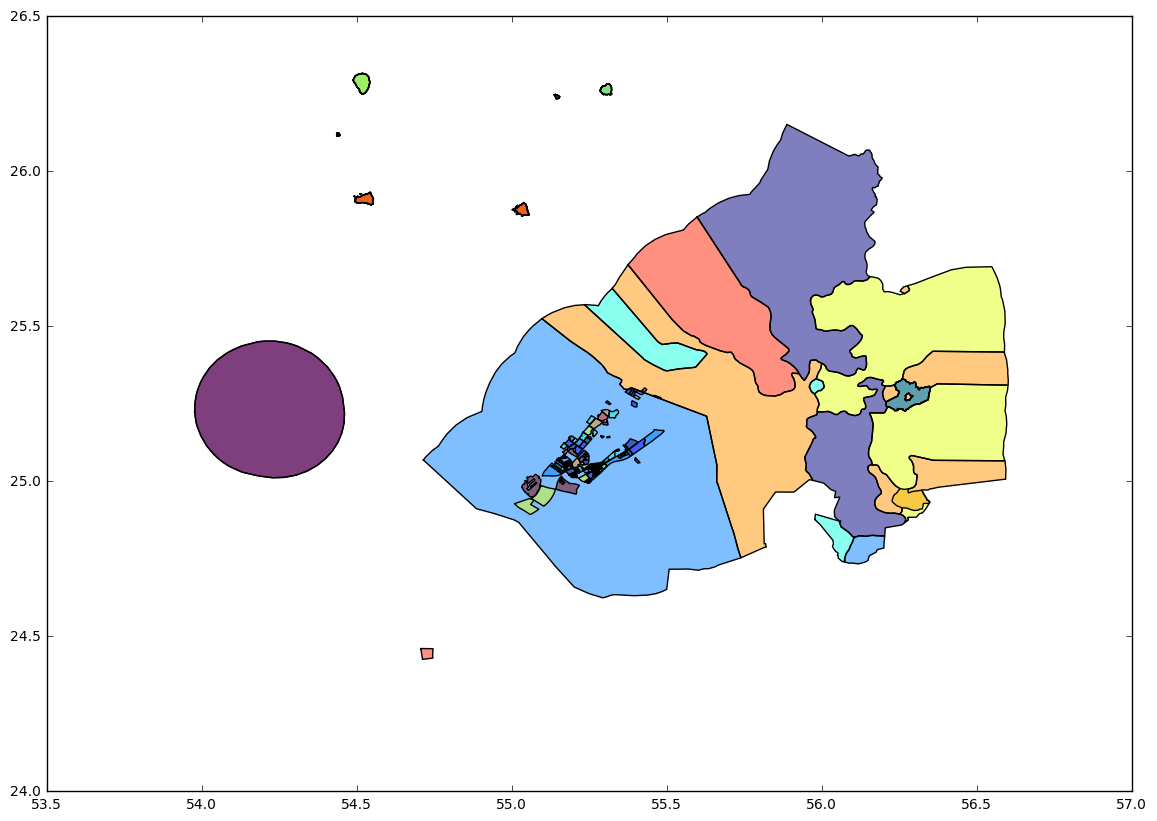

In [47]:
hide_code
# Setup the size of the image
matplotlib.rcParams['figure.figsize'] = (14, 14)
# plt.figure(figsize=(14,14))
# Print map
df_admin.plot()
plt.show()

In [48]:
hide_code
df_roads.head(3)

,access,bridge,class,geometry,id,name,oneway,osm_id,ref,service,tunnel,type,z_order
0,None,0,highway,LINESTRING (55.32015262128414 25.2757784276593...,1.0,None,0,4342763.0,None,None,0,residential,3.0
1,None,0,highway,LINESTRING (55.31645762690815 25.2760928328473...,2.0,None,0,4342765.0,None,None,0,residential,3.0
2,None,0,highway,LINESTRING (55.36891333716767 25.2681990917146...,3.0,None,0,4387626.0,None,None,0,residential,3.0


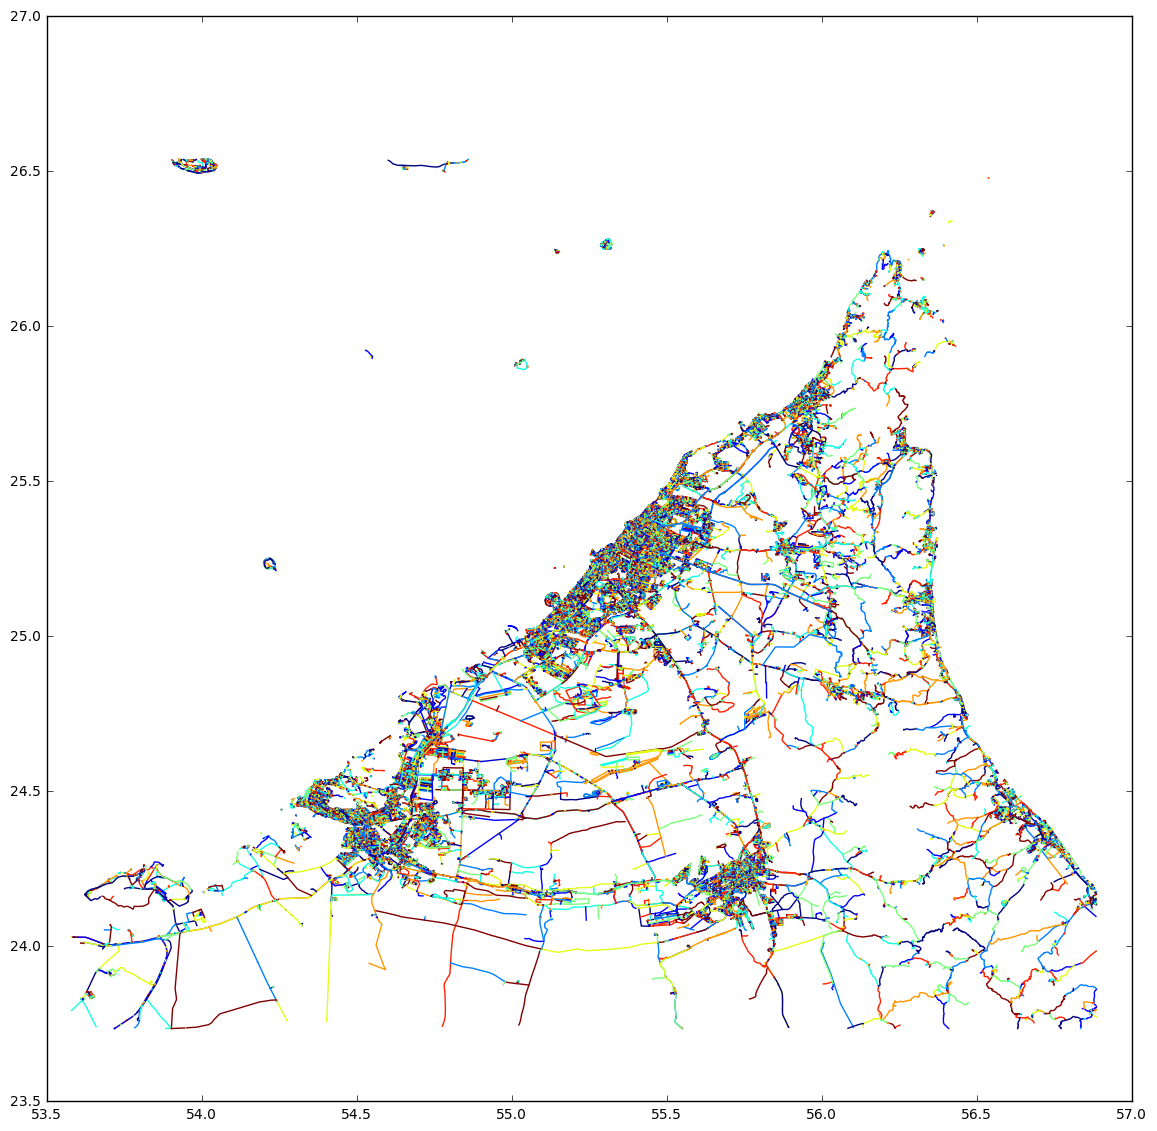

In [65]:
hide_code
matplotlib.rcParams['figure.figsize'] = (14, 14)
df_roads.plot()
plt.show()

In [49]:
hide_code
df_waterareas.head(3)

,area,geometry,id,name,osm_id,type
0,0.000007,"POLYGON ((55.16472162631962 25.06663418550218,...",1.0,None,-2809.0,water
1,0.000001,"POLYGON ((55.33883487762949 25.24116309539045,...",2.0,None,-1271995.0,water
2,0.000001,"POLYGON ((55.15874105458627 25.07026178937664,...",3.0,None,-2812.0,water


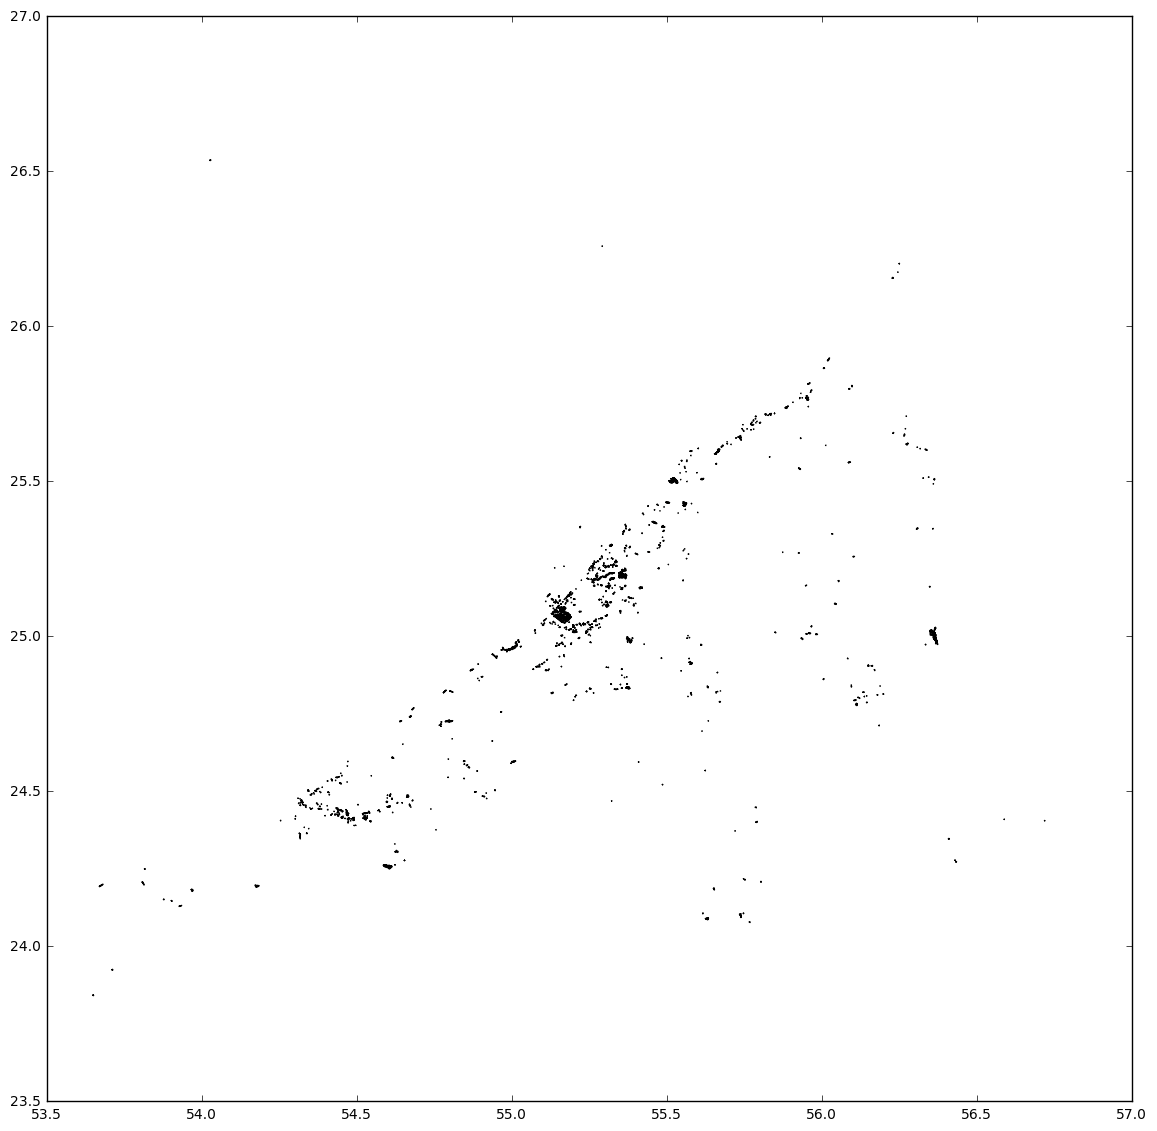

In [69]:
hide_code
matplotlib.rcParams['figure.figsize'] = (14, 14)
df_waterareas.plot()
plt.show()

##### 1.7 Shapefiles

For displaying the data in shapefiles it's possible to apply the package "basemap". As an example you can see the map of  roads and aeroways.

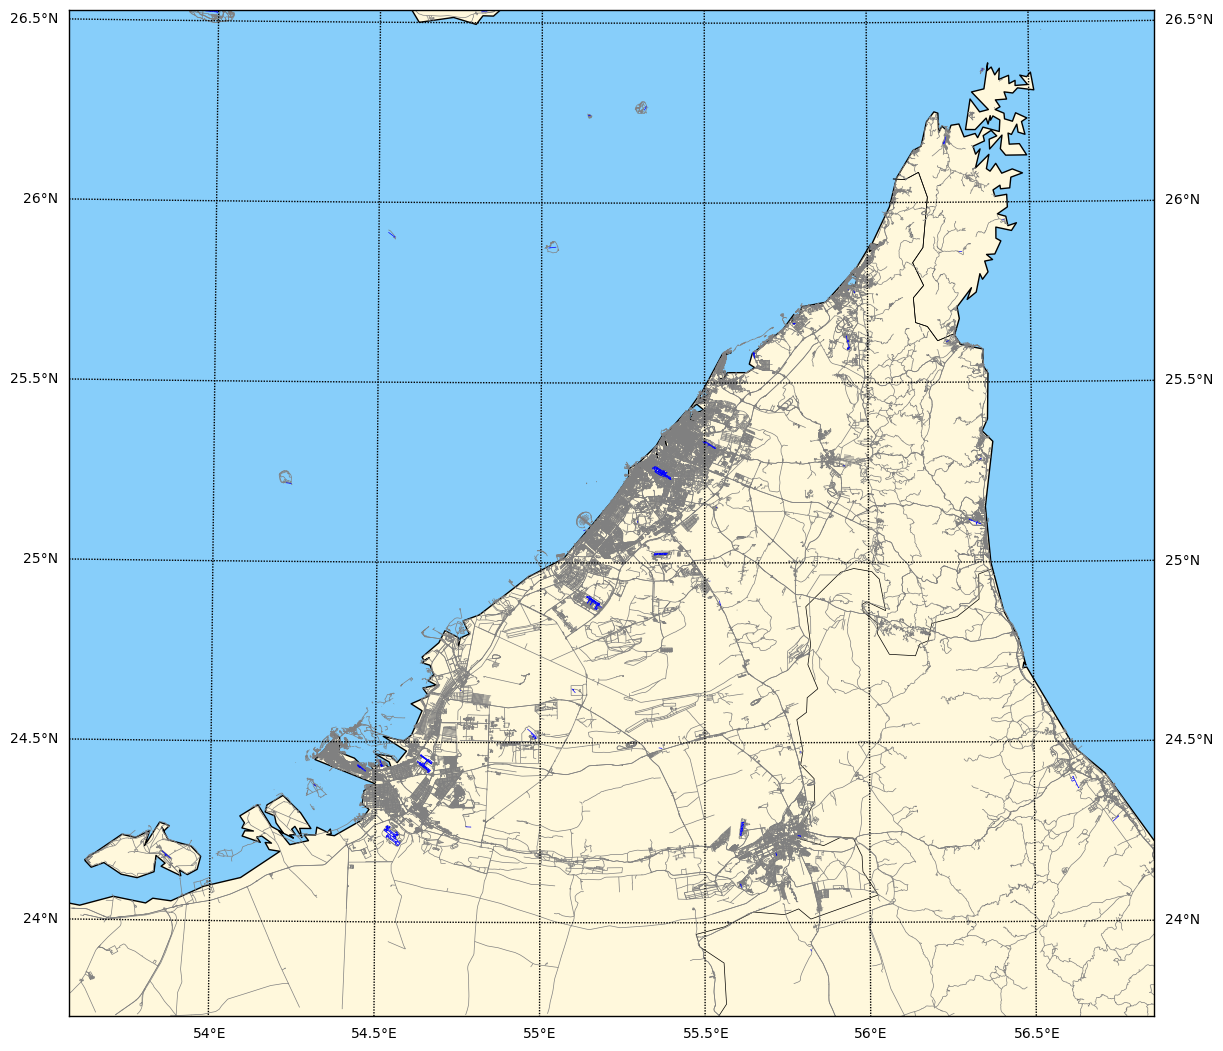

In [70]:
hide_code
# Setup the size of the image
matplotlib.rcParams['figure.figsize'] = (14, 14)
# Setup the colors for surfaces
water = 'lightskyblue'
earth = 'cornsilk'
# Create a map
mm = Basemap(llcrnrlon=53.58, llcrnrlat=23.73, urcrnrlon=56.89, urcrnrlat=26.53, 
             ellps='WGS84', resolution='i', projection='cass', lat_0 = 25.0756, lon_0 = 55.3821)
# Variables for drawing map components
coast = mm.drawcoastlines()
rivers = mm.drawrivers(color=water, linewidth=1)
continents = mm.fillcontinents(color=earth,lake_color=water)
bound= mm.drawmapboundary(fill_color=water)
countries = mm.drawcountries()
merid = mm.drawmeridians(np.arange(-180, 180, 0.5), labels=[False, False, False, True])
parall = mm.drawparallels(np.arange(0, 80, 0.5), labels=[True, True, False, False])
# Read shapefiles
mm.readshapefile('/Users/olgabelitskaya/large-repo/dubai_abu-dhabi.imposm-shapefiles/dubai_abu-dhabi_osm_roads', 
                 name='roads', drawbounds=True, color='grey')
mm.readshapefile('/Users/olgabelitskaya/large-repo/dubai_abu-dhabi.imposm-shapefiles/dubai_abu-dhabi_osm_aeroways', 
                 name='aeroways', drawbounds=True, color='blue')
# Display the map
plt.show()

##### 1.8 Json file

Applying the special function (§ 0.3) I created the dubai_abu-dhabi.osm.json from the dubai_abu-dhabi.osm file.

In [68]:
hide_code
# Extract data from the dataset in the .osm format as json files
# data1 = process_map(file1)

''

In [31]:
hide_code
# Setup the variable for the .json file
file7 = filedir1 + 'dubai_abu-dhabi.osm.json'

In [32]:
hide_code
# Get size of the .json file
print "size of dubai_abu-dhabi.osm.json: ", os.path.getsize(file7)

size of dubai_abu-dhabi.osm.json:  458155339


### 2. Data (OSM)

Let's discover the data in .osm files in details. It contains a lot of information of geographical objects.

##### 2.1 Tags

OpenStreetMap represents physical features on the ground (e.g., roads or buildings) using tags attached to its basic data structures (its nodes, ways, and relations). 
Tags help describe an item and allow it to be found again by browsing or searching. They are chosen by the item's creator depending on the data point.

In [80]:
hide_code
# Count tags
print count_tags(file1)

defaultdict(<type 'int'>, {'node': 1890178, 'nd': 2271372, 'bounds': 1, 'member': 9779, 'tag': 503027, 'relation': 2820, 'way': 234327, 'osm': 1})


##### 2.2 Users

Map data is collected from zero by volunteers (users). We can get the number and the list of them for this piece of the data.

In [57]:
hide_code
# Count users of the map editing
users1 = process_map_users(file1)

In [58]:
hide_code
# Display number of users
print "Number of users -", len(users1)
# Display example of the user list
user_list = list(users1)
print sorted(user_list)[:50]

Number of users - 1895
['-KINGSMAN-', '0508799996', '08xavstj', '12DonW', '12Katniss', '13 digits', '25837', '3abdalla', '4b696d', '4rch', '66444098', '7dhd', '@kevin_bullock', 'AAANNNDDD', 'AC FootCap', 'AE35', 'AHMED ABASHAR', 'AKazariani', 'ASHRAF CHOOLAKKADAVIL', 'A_Sadath', 'AakankshaR', 'Aal Ibra240380heem', 'Abbadi', 'Abdalmajeed Najmi', 'Abdelhadi Azaizeh', 'Abdul Noor Bank', 'Abdul Rahim Khan', 'Abdul wahab rashid', 'Abdulaziz AlSweda', 'Abdulla Shuqair', 'Abdullah Al Hany', 'Abdullah Alshareef', 'Abdullah Rana', 'Abdullah777', 'Abdurehman', 'AbeMazid', 'Abhin', 'Abiodun Babalola', 'Abllo', 'Aboad Jasim', 'Abood Ad', 'Abrarbhai', 'Absamc', 'AbuFazal', 'Abud', 'Adel alsaad', 'Adib Yz', 'Adil Alsuleimani', 'Adley', 'Adm Vtc']


Exploring the digital data in this file, we can get a large number of other statistics and information.

##### 2.3 Keys

In [66]:
hide_code
# Count keys by types
process_map_keys(file1)

{'lower': 479404, 'lower_colon': 20602, 'other': 3001, 'problemchars': 20}

##### 2.4 Number of street addresses

In [67]:
hide_code
# Count street addresses
street_number(file1)

1789

##### 2.5 Places

In [84]:
hide_code
# Count places by types
print process_map_places(file1)

 {'town': 31, 'city': 13, 'island': 67, 'hamlet': 97, 'other': 749, 'village': 608}


##### 2.6 Names in English

In [85]:
hide_code
# Count names in english with values
english_names1 = process_map_names(file1)

In [86]:
hide_code
print "The number of names in English: ", english_names1[0]

The number of names in English:  3413


In [87]:
hide_code
print list(english_names1[1])[:50]

['Tawi Madsus', 'Bani Umar', 'Jabal Nazifi', 'Umm Al Quwain', 'Le Mart', 'DoT Scrap Store', 'Buraimi Police station', 'CEREEN Textiles', 'Faseela Grocery', 'Al Muwaylah', 'Najman Grocery', 'Ras Huwayni', 'Al Musalall Grocery', 'Huwayniyah', 'Dariush Boulevard', 'OM YAMAN', 'Azerbayejan', 'Ayn al Mahab', 'Saad Pharmacy', 'Nabil house', 'Al Jowar', 'Zarub', 'Dubai Homeopathy Health Centre', 'Wadi Massayid', 'New academey school', 'Mohd Ibrahn Grocery', 'Ramlat Qasf', 'Fujayj', 'Harat ash Shaykh', 'Subtan', 'VMS-19', 'Emirates Towers', 'Qurun Hamad', 'Ruqat Bakhit', 'Tawi Salim', 'Carrefour City', 'mini mart', 'Al Husaifin', 'Darwish Lshkari Grocery', 'Wadi Hiyar', 'Khawr Naid', 'Wadi Sidr', 'Hadirah', 'Al Darak Grocery', 'Holiday Mini Mart', 'Sharyat Ayqal', 'Ras Humsi', 'Dansaf', 'Tawi Saghabah', 'Wadi Shukayyah']


On this map it may be noted a large number of duplicate names in English.

##### 2.7 Postal Codes

In UAE mail is usually delivered to a P.O Box. As we can see practically all postcodes are individual. Let's display the list of P.O Boxes and the number of users for each of them (1-2 in the most of cases).

In [93]:
hide_code
print "The number of postcodes:", zip_codes(file1)[0]

The number of postcodes: 116


In [89]:
hide_code
# Audit P.O Box
postcode1 = process_map_postcodes(file1)

In [90]:
hide_code
# Display  P.O Box
print postcode1

{'00962': 1, '34121': 1, '7819': 1, '108100': 1, 'P.O. Box 5618, Abu Dhabi, U.A.E': 1, '8988': 1, '0': 1, '23117': 2, 'P O BOX 3766': 1, '103711': 2, '549': 1, '38495': 1, 'P.O. Box 4605': 1, 'Muhaisnah 4': 1, '20767': 1, '81730': 1, '2504': 1, 'PO Box 6770': 1, '8845': 1, 'PO Box 43377': 1, '97717': 1, '24857': 3, '232574': 1, 'P.O. Box 9770': 1, '60884': 1, '44263': 1, '277': 1, '16095': 1, 'P. O. Box 31166': 1, '502227': 1, '2666': 1, '41318': 1, 'P. O. Box 123234': 1, '00971': 1, '128358': 1, '79506': 1, '115443': 1, '500368': 1, '473828': 4, '28676': 1, '114692': 1, '232144': 1, '2574': 1, '121641': 1, '1243': 1, '125939': 2, 'PO Box 118737': 1, '57566': 1, '6834': 2, '28818': 1, 'PO Box 114822': 1, '42524': 1, '52799': 1, '2157': 1, '392189': 1, '9978': 1, '22436': 3, '231992': 1, '46477': 1, '5280 dubai': 1, '811': 5, '42324': 1, '12345': 1, '38126': 1, '113431': 1, '64649': 1, '47612': 1, '24976': 1, 'P.O. Box 6446': 1, '111695': 1, '41974': 1, '44548': 1, '0000': 1, '119417': 

##### 2.8 Street names

In [59]:
hide_code
# Audit street names
street_names1 = audit_street_names(file1)

In [60]:
hide_code
# Display street names
pprint.pprint(dict(street_names1))

{'07': set(['07']),
 '1': set(['20B Street, Safa 1',
           'City Walk, Jumeirah 1',
           'E 1',
           'Hattan Street 1',
           'aljurf ind 1']),
 '10': set(['Street 10', 'ind area 10']),
 '11': set(['shabiya -11']),
 '111': set(['P.O.Box 111']),
 '12': set(['District 12', 'Street 12']),
 '12A': set(['12A']),
 '12K': set(['District 12K']),
 '13': set(['Street 13', 'industrial 13', 'street 13\n']),
 '14': set(['11th street, Musaffah M 14',
            'Musaffah Industrial Area Street 14']),
 '147': set(['147']),
 '15': set(['sweet 15']),
 '153': set(['Community 153']),
 '166': set(['166']),
 '17': set(['17']),
 '18': set(['Street 18', 'street 18']),
 '19': set(['19']),
 '19th)': set(["Sa'ada Street (19th)"]),
 '1D': set(['1D']),
 '2': set(['Al Barsha south 2',
           'Al Jaddaf 2',
           'Al Nahda 2',
           'Dragon Mart 2',
           'Dubai Investment Park 2',
           'Hattan Street 2',
           'Icad 2',
           'Street 2',
           'dubai i

In [61]:
hide_code
# Update street names
for street_type, ways in street_names1.iteritems():
    for name in ways:
        better_name = update_name(name, mapping, street_type_re)
        print name, "=>", better_name

Al Nayhan => Al Nayhan
Al Sufouh Rd => Al Sufouh Road
JBR Rd => JBR Road
Sheikh Rashed Bin Said Rd => Sheikh Rashed Bin Said Road
Oud Metha Rd => Oud Metha Road
Al Safouh Rd => Al Safouh Road
Jumeirah Beach Rd => Jumeirah Beach Road
Al Hudaiba Road, Al Badaa
=> Al Hudaiba Road, Al Badaa

14th Street, Al Khalidiya, Near Saba Crownn => 14th Street, Al Khalidiya, Near Saba Crownn
Newbridge Hill => Newbridge Hill
Dubai Ibn Battuta Gate => Dubai Ibn Battuta Gate
Oud Metha => Oud Metha
12A => 12A
Maraya Art Centre, Al Qasba => Maraya Art Centre, Al Qasba
P.O.Box 74147 => P.O.Box 74147
residential => residential
District 12K => District 12K
The Dome => The Dome
industrial 4 => industrial 4
Al Qaram Br => Al Qaram Br
The Walk, Dubai Marina => The Walk, Dubai Marina
Dubai Marina => Dubai Marina
Street 8 => Street 8
MUROOR ROAD => MUROOR Road
Al Ghuwair Building => Al Ghuwair Building
SouthRidge Branch, Downtown Dubai => SouthRidge Branch, Downtown Dubai
Street 13, Dubai => Street 13, Dubai
Silv

More accurate correction is possible by comparison with data from other map sites and in the studying of the real situation.

### 3. JSON & Mongo DB

##### 3.1 Database
There are several ways for inserting and quering json files into Mongo DB.

##### Variant #1

In [ ]:
hide_code
conn = pymongo.MongoClient("mongodb://localhost")
db = conn.test
openstreetmap = db.test_collection
jsonfile = ("dubai_abu-dhabi.osm.json", 'r')

In [ ]:
hide_code
parsedfile = json.loads(jsonfile.read())

In [ ]:
hide_code
for item in parsedfile["Records"]:
    openstreetmap.insert(item)

##### Variant #2

In [71]:
hide_code
# Build mongoimport command 
# collection = file1[:file1.find('.')]
collection = 'dubai_abu_dhabi'
mongoimport_cmd = 'mongoimport -h 127.0.0.1:27017 ' + '--db ' + db_name + \
                  ' --collection ' + collection + ' --file ' + file7

# Drop collection (if it's already running) 
if collection in database.collection_names():
    print 'Dropping collection: ' + collection
    database[collection].drop()
    
# Execute the command
print 'Executing: ' + mongoimport_cmd

Dropping collection: dubai_abu_dhabi
Executing: mongoimport -h 127.0.0.1:27017 --db openstreetmap_dubai --collection dubai_abu_dhabi --file /Users/olgabelitskaya/large-repo/dubai_abu-dhabi.osm.json


In [59]:
hide_code
import signal
import subprocess
pro = subprocess.Popen('mongod', preexec_fn = os.setsid)

In [23]:
hide_code
# Setup the variable for the mongo db collection
from pymongo import MongoClient
client = MongoClient('localhost:27017')
database = client['test']
dubai_abu_dhabi = database['openstreetmap']

In [83]:
hide_code
# subprocess.call(mongoimport_cmd.split())

##### 3.2 Indicators of the dataset

In [81]:
hide_code
# Count documents, nodes and ways
print "Documents: ", dubai_abu_dhabi.find().count()
print "Nodes: ", dubai_abu_dhabi.find({'type':'node'}).count()
print "Ways: ", dubai_abu_dhabi.find({'type':'way'}).count()

Documents:  2124505
Nodes:  1890130
Ways:  234063


Let's have a look on one example of the document in this database. It represents the structure of the data in our case.

In [58]:
hide_code
# Display an example of documents
print dubai_abu_dhabi.find_one()

{u'pos': [25.1966689, 55.3090868], u'_id': ObjectId('582f4a0cfb1e7f49e75de213'), u'type': u'node', u'id': u'21133785', u'created': {u'changeset': u'12645525', u'version': u'9', u'user': u'Tommy', u'timestamp': u'2012-08-07T13:29:47Z', u'uid': u'18885'}}


##### 3.3 Users

In [82]:
hide_code
# Count users
print "Number of users: ", len(dubai_abu_dhabi.distinct('created.user'))

Number of users:  1885


In [85]:
hide_code
# Create list of users
user_list_mongo = dubai_abu_dhabi.distinct('created.user')
# Display some user names
print "List of the first 50 user names:"
print sorted(user_list_mongo)[:50]

List of the first 50 user names:
[u'-KINGSMAN-', u'0508799996', u'08xavstj', u'12DonW', u'12Katniss', u'13 digits', u'25837', u'3abdalla', u'4b696d', u'4rch', u'66444098', u'7dhd', u'@kevin_bullock', u'AAANNNDDD', u'AC FootCap', u'AE35', u'AHMED ABASHAR', u'AKazariani', u'ASHRAF CHOOLAKKADAVIL', u'A_Sadath', u'AakankshaR', u'Aal Ibra240380heem', u'Abbadi', u'Abdalmajeed Najmi', u'Abdelhadi Azaizeh', u'Abdul Noor Bank', u'Abdul Rahim Khan', u'Abdul wahab rashid', u'Abdulaziz AlSweda', u'Abdulla Shuqair', u'Abdullah Al Hany', u'Abdullah Alshareef', u'Abdullah Rana', u'Abdullah777', u'Abdurehman', u'AbeMazid', u'Abhin', u'Abiodun Babalola', u'Aboad Jasim', u'Abood Ad', u'Abrarbhai', u'Absamc', u'AbuFazal', u'Abud', u'Adel alsaad', u'Adib Yz', u'Adil Alsuleimani', u'Adley', u'Adm Vtc', u'Adnaan Abrahams']


The database allows to evaluate the contribution of each individual user in map editing.

In [86]:
hide_code
# Count documents by user
print "Number of notes for the user Ahmed Silo: ", \
dubai_abu_dhabi.find({"created.user": "Ahmed Silo"}).count()

Number of notes for the user Ahmed Silo:  7


In [87]:
hide_code
# Display documents by user
print "The note of the user Ahmed Silo: "
for element in dubai_abu_dhabi.find({"created.user": "Ahmed Silo"}).sort("timestamp"):
    print element

The note of the user Ahmed Silo: 
{u'amenity': u'hospital', u'name': u'Lifeline Hospital', u'emergency': u'yes', u'created': {u'changeset': u'15753505', u'version': u'2', u'user': u'Ahmed Silo', u'timestamp': u'2013-04-16T18:40:04Z', u'uid': u'1363849'}, u'pos': [25.0292611, 55.1147026], u'_id': ObjectId('58339b2778c5c4115e93545f'), u'type': u'node', u'id': u'626423070'}
{u'amenity': u'school', u'name': u'Jebel Ali Primary School', u'created': {u'changeset': u'15753505', u'version': u'2', u'user': u'Ahmed Silo', u'timestamp': u'2013-04-16T18:46:35Z', u'uid': u'1363849'}, u'pos': [25.0297763, 55.1139623], u'_id': ObjectId('58339b2778c5c4115e935461'), u'type': u'node', u'id': u'626429819'}
{u'amenity': u'kindergarten', u'name': u'Chubby cheeks Nursary', u'created': {u'changeset': u'15753505', u'version': u'1', u'user': u'Ahmed Silo', u'timestamp': u'2013-04-16T18:34:52Z', u'uid': u'1363849'}, u'pos': [25.0470894, 55.1296555], u'address': {}, u'_id': ObjectId('58339c7e78c5c4115e9facc2'), 

With the help of simple manipulations in the database, the user can perform a selection of interesting information.

Let us list the most active editors of this map section:

In [111]:
hide_code
# Create a list of 3 top users
top_users = dubai_abu_dhabi.aggregate([
    { "$group" : {"_id" : "$created.user", "count" : { "$sum" : 1} } }, 
    { "$sort" : {"count" : -1} }, { "$limit" : 3 } 
] )
print list(top_users)

[{u'_id': u'eXmajor', u'count': 492808},
 {u'_id': u'chachafish', u'count': 156874},
 {u'_id': u'Seandebasti', u'count': 125767}]

The number of users with one note and the list of 10 users with only one note:

In [112]:
hide_code
# Count users with one post
onetime_users = dubai_abu_dhabi.aggregate( [
    { "$group" : {"_id" : "$created.user", "count" : { "$sum" : 1} } },
    { "$group" : {"_id" : "$count", "num_users": { "$sum" : 1} } },
    { "$sort" : {"_id" : 1} }, { "$limit" : 1} 
] )
list(onetime_users)

[{u'_id': 1, u'num_users': 646}]

In [113]:
hide_code
# Create a list of 10 users with one post
list_onetime_users = dubai_abu_dhabi.aggregate([
    { "$group" : {"_id" : "$created.user", "count" : { "$sum" : 1} } }, 
    { "$sort" : {"count" : 1} }, { "$limit" : 10 } 
] )
print list(list_onetime_users)

[{u'count': 1, u'_id': u'ganesh reddy'}, {u'count': 1, u'_id': u'Msmsms99'}, {u'count': 1, u'_id': u'Rjensky'}, {u'count': 1, u'_id': u'thajudeen n'}, {u'count': 1, u'_id': u'aceman444'}, {u'count': 1, u'_id': u'Haseeb1973'}, {u'count': 1, u'_id': u'I\u0148n\xf4\xc7\xeb\u0148t R\xe4h\xfal P\xe4l'}, {u'count': 1, u'_id': u'Khadar Mohaideen'}, {u'count': 1, u'_id': u'Niyas Badarudeen'}, {u'count': 1, u'_id': u'Emma Danny'}]


##### 3.4 Places

The list of 3 most common places:

In [114]:
hide_code
# Create a list of 3 most common places
places = dubai_abu_dhabi.aggregate( [ 
    { "$match" : { "address.place" : { "$exists" : 1} } }, 
    { "$group" : { "_id" : "$address.place", "count" : { "$sum" : 1} } },  
    { "$sort" : { "count" : -1}}, {"$limit":3}
] )
print list(places)

[{u'_id': u'Yas Mall', u'count': 14},
 {u'_id': u'Jumeirah Village Triangle', u'count': 10},
 {u'_id': u'Deerfields Townsquare Shopping Centre', u'count': 2}]

The list of 10 most common types of buildings:

In [115]:
hide_code
# Create a list of 10 most common types of buildings
buildings = dubai_abu_dhabi.aggregate([
        {'$match': {'building': { '$exists': 1}}}, 
        {'$group': {'_id': '$building','count': {'$sum': 1}}}, 
        {'$sort': {'count': -1}}, {'$limit': 10}
    ])
list(buildings)

[{u'_id': u'yes', u'count': 43834},
 {u'_id': u'house', u'count': 4216},
 {u'_id': u'apartments', u'count': 2910},
 {u'_id': u'residential', u'count': 2606},
 {u'_id': u'roof', u'count': 1026},
 {u'_id': u'hangar', u'count': 825},
 {u'_id': u'warehouse', u'count': 380},
 {u'_id': u'mosque', u'count': 378},
 {u'_id': u'garage', u'count': 314},
 {u'_id': u'commercial', u'count': 313}]

The list of 10 most common facilities:

In [116]:
hide_code
# Create a list of 10 most common facilities
facilities = dubai_abu_dhabi.aggregate([
        {'$match': {'amenity': {'$exists': 1}}}, 
        {'$group': {'_id': '$amenity', 'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}, {'$limit': 10}
    ])
list(facilities)

[{u'_id': u'parking', u'count': 5602},
 {u'_id': u'place_of_worship', u'count': 1443},
 {u'_id': u'restaurant', u'count': 1372},
 {u'_id': u'school', u'count': 489},
 {u'_id': u'fast_food', u'count': 442},
 {u'_id': u'fuel', u'count': 438},
 {u'_id': u'cafe', u'count': 403},
 {u'_id': u'bank', u'count': 317},
 {u'_id': u'pharmacy', u'count': 311},
 {u'_id': u'shelter', u'count': 247}]

The list of 3 most common zipcodes:

In [117]:
hide_code
# Create a list of 3 most common zipcodes
top_zipcodes = dubai_abu_dhabi.aggregate( [ 
    { "$match" : { "address.postcode" : { "$exists" : 1} } }, 
    { "$group" : { "_id" : "$address.postcode", "count" : { "$sum" : 1} } },  
    { "$sort" : { "count" : -1}}, {"$limit": 3}
] )
list(top_zipcodes)

[{u'_id': u'811', u'count': 5},
 {u'_id': u'473828', u'count': 4},
 {u'_id': u'24857', u'count': 3}]

Counting zipcodes with one document:

In [119]:
hide_code
# Count zipcodes with one document
onetime_zipcodes = dubai_abu_dhabi.aggregate( [ 
    { "$group" : {"_id" : "$address.postcode", "count" : { "$sum" : 1} } },
    { "$group" : {"_id" : "$count", "count": { "$sum" : 1} } },
    { "$sort" : {"_id" : 1} }, { "$limit" : 1} 
] )
list(onetime_zipcodes)

[{u'_id': 1, u'count': 85}]

##### 3.5 Update values in Mongo DB
At the preliminary stage of familiarization with the information in the osm file problem and erroneous points in the dataset were found.

Now we can replace the wrong values and decide many important tasks at the same time: 
- check the data about concrete geoobjects, 
- use additional information in fields, 
- update values.

#### 3.5.1 One value
The example of the document with the wrong value:

In [136]:
hide_code
dubai_abu_dhabi.find_one({'address.street':'Twam St.'})

{u'_id': ObjectId('58339f5578c5c4115eb124ff'),
 u'address': {u'city': u'Al Ain', u'street': u'Twam St.'},
 u'building': u'residential',
 u'created': {u'changeset': u'22394079',
  u'timestamp': u'2014-05-17T18:34:16Z',
  u'uid': u'2079950',
  u'user': u'Anna23',
  u'version': u'1'},
 u'id': u'282551277',
 u'name': u"Maqam 2 Female Students' Accomodation",
 u'node_refs': [u'2864941597',
  u'2864941598',
  u'2864941599',
  u'2864941600',
  u'2864942001',
  u'2864941597'],
 u'type': u'way'}

The process of replacing:

In [92]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339c6b78c5c4115e9f47e9')}, 
                           {'$set': {'address.street': 'Al Sufouh Road'}}, upsert=False)

In [86]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339ba178c5c4115e97e58d')}, 
                           {'$set': {'address.street': 'Sheikh Rashed Bin Said Road'}}, 
                           upsert=False)

In [89]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339dab78c5c4115ea6fc12')}, 
                           {'$set': {'address.street': 'Oud Metha Road'}}, upsert=False)

In [95]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339d5578c5c4115ea45b8d')}, 
                           {'$set': {'address.street': 'Al Sufouh Road'}}, upsert=False)

In [112]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339c6b78c5c4115e9f47e5')}, 
                           {'$set': {'address.street': 'Oud Metha Road'}}, upsert=False)

In [131]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339f7878c5c4115eb287b1')}, 
                           {'$set': {'address.street': 'Al Falak Street'}}, upsert=False)

In [137]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339f5578c5c4115eb124ff')}, 
                           {'$set': {'address.street': 'Twam Street'}}, upsert=False)

The example of checking the result:

In [138]:
hide_code
dubai_abu_dhabi.find_one({'_id': ObjectId('58339f5578c5c4115eb124ff')})

{u'_id': ObjectId('58339f5578c5c4115eb124ff'),
 u'address': {u'city': u'Al Ain', u'street': u'Twam Street'},
 u'building': u'residential',
 u'created': {u'changeset': u'22394079',
  u'timestamp': u'2014-05-17T18:34:16Z',
  u'uid': u'2079950',
  u'user': u'Anna23',
  u'version': u'1'},
 u'id': u'282551277',
 u'name': u"Maqam 2 Female Students' Accomodation",
 u'node_refs': [u'2864941597',
  u'2864941598',
  u'2864941599',
  u'2864941600',
  u'2864942001',
  u'2864941597'],
 u'type': u'way'}

#### 3.5.2 Several mistakes in one field
The example of the document with the wrong value:

In [26]:
hide_code
dubai_abu_dhabi.find_one({'address.street':'al khail gate'})

{u'_id': ObjectId('58339efa78c5c4115eae59a3'),
 u'address': {u'street': u'al khail gate'},
 u'created': {u'changeset': u'41420905',
  u'timestamp': u'2016-08-13T00:05:58Z',
  u'uid': u'4413209',
  u'user': u'AKazariani',
  u'version': u'1'},
 u'id': u'4348061189',
 u'name': u'West Zone',
 u'opening_hours': u'24/7',
 u'pos': [25.1388211, 55.2534068],
 u'shop': u'supermarket',
 u'type': u'node'}

The process of replacing:

In [100]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339c6b78c5c4115e9f47e4')}, 
                           {'$set': {'address.street': 'Jumeirah Beach Road'}}, upsert=False)

In [128]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339b6f78c5c4115e95ebec')}, 
                           {'$set': {'address.street': 'Al Nahda Road'}}, upsert=False)

In [134]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339f1c78c5c4115eaf100b')}, 
                           {'$set': {'address.street': 'Jumeirah Beach Road'}}, upsert=False)

In [27]:
dubai_abu_dhabi.update_one({'_id': ObjectId('58339efa78c5c4115eae59a3')}, 
                           {'$set': {'address.street': 'Al Khail Gate Phase II'}}, upsert=False)

The example of checking the result:

In [28]:
hide_code
dubai_abu_dhabi.find_one({'_id': ObjectId('58339efa78c5c4115eae59a3')})

{u'_id': ObjectId('58339efa78c5c4115eae59a3'),
 u'address': {u'street': u'Al Khail Gate Phase II'},
 u'created': {u'changeset': u'41420905',
  u'timestamp': u'2016-08-13T00:05:58Z',
  u'uid': u'4413209',
  u'user': u'AKazariani',
  u'version': u'1'},
 u'id': u'4348061189',
 u'name': u'West Zone',
 u'opening_hours': u'24/7',
 u'pos': [25.1388211, 55.2534068],
 u'shop': u'supermarket',
 u'type': u'node'}

#### 3.5.3 Several fields
The example of the document with the wrong value:

In [139]:
hide_code
dubai_abu_dhabi.find_one({'address.street':'Jawazath Road, Behind Mashreq Bank, Sharjah'})

{u'_id': ObjectId('58339cf478c5c4115ea2de71'),
 u'address': {u'street': u'Jawazath Road, Behind Mashreq Bank, Sharjah'},
 u'amenity': u'Grill, Cebab',
 u'created': {u'changeset': u'19745669',
  u'timestamp': u'2014-01-01T14:33:36Z',
  u'uid': u'476310',
  u'user': u'taipovm',
  u'version': u'1'},
 u'id': u'2604495796',
 u'name': u'Al Safadi',
 u'phone': u'050-2484004',
 u'pos': [25.3430079, 55.3910065],
 u'type': u'node'}

The process of replacing:

In [109]:
dubai_abu_dhabi.update_many({'_id': ObjectId('58339f0e78c5c4115eaed507')}, 
                            {'$set': {'address.city': 'Abu Dhabi', 
                                      'address.street': '',
                                      'address.neighbourhood': 'Al Nahyan',
                                      'pos': [24.455225, 54.396046]}}, 
                            upsert=False)

In [118]:
dubai_abu_dhabi.update_many({'_id': ObjectId('58339edb78c5c4115ead54d0')}, 
                            {'$set': {'address.city': 'Abu Dhabi', 
                                      'address.street': '14th Street',
                                      'address.neighbourhood': 'Al Khalidiya'}}, 
                            upsert=False)

In [122]:
dubai_abu_dhabi.update_many({'_id': ObjectId('58339f1a78c5c4115eaefe75')}, 
                            {'$set': {'address.street': 'Al Safouh Street',
                                      'pos': [25.075998, 55.135681]}}, 
                            upsert=False)

In [125]:
dubai_abu_dhabi.update_many({'_id': ObjectId('58339ea578c5c4115eabbd89')}, 
                            {'$set': {'address.city': 'Abu Dhabi',
                                      'address.street': 'Dhafeer Street',
                                      'pos': [24.433780, 54.439363]}}, 
                            upsert=False)

In [141]:
dubai_abu_dhabi.update_many({'_id': ObjectId('58339cf478c5c4115ea2de71')}, 
                            {'$set': {'address.city': 'Sharjah', 
                                      'address.street': 'Jawazath Road',
                                      'address.neighbourhood': 'Al Qasimia',
                                      'pos': [25.343122, 55.390882]}}, 
                            upsert=False)


The example of checking the result:

In [142]:
hide_code
dubai_abu_dhabi.find_one({'_id': ObjectId('58339cf478c5c4115ea2de71')})

{u'_id': ObjectId('58339cf478c5c4115ea2de71'),
 u'address': {u'city': u'Sharjah',
  u'neighbourhood': u'Al Qasimia',
  u'street': u'Jawazath Road'},
 u'amenity': u'Grill, Cebab',
 u'created': {u'changeset': u'19745669',
  u'timestamp': u'2014-01-01T14:33:36Z',
  u'uid': u'476310',
  u'user': u'taipovm',
  u'version': u'1'},
 u'id': u'2604495796',
 u'name': u'Al Safadi',
 u'phone': u'050-2484004',
 u'pos': [25.343122, 55.390882],
 u'type': u'node'}

### 4. Problems and errors

##### 4.1 
One of the main problems of public maps - no duplication of all place names in other languages. If it were possible to automate the translation process by increasing a common database of map names in many languages, it would save users from many difficulties and mistakes.

##### 4.2
The next problem - the presence of a large number of databases (including mapping) on the same map objects. Some intergraph procedures of already available data would relieve a lot of people from unnecessary work, save time and effort.

##### 4.3
Obviously, the information about the number of buildings and their purpose is incomplete. Completeness of public maps can be increased by bringing in the process of mapping new users. For this goal enter the information should be as simple as possible: for example, a choice of the available options with automatic filling many fields for linked options (for example, linking the name of the street and the administrative area in which it is located).

##### 4.4 
There are a number of mistakes and typos as in every public data. For correction them well-known methods can be proposed: automatic comparison with existing data and verification for new data by other users.

##### 4.5
The lack of a uniform postal code system in this concrete dataset complicates their identification and verification.

##### 4.6
During working on the project, I spent a lot of time on the conversion of one type of data file to another. Each format has its own advantages and disadvantages. Probably, it is possible to design a universal file type that allows us to store data of any kind, combining the advantages of all existing types and applicable in the most of existing programming languages.

##### 4.7
Correction of errors made in the data seems to me appropriate to carry out after uploading files to the database. Sometimes a record that is a mistake in terms of filling a particular type of data just contains additional information about geoobjects.

### 5. Data Overview

##### 5.1 Description of the data structure: 
1) nodes -  points in space with basic characteristics (lat, long, id, tags);

2) ways - defining linear features and area boundaries (an ordered list of nodes);

3) relations - tags and also an ordered list of nodes, ways and/or relations as members which is used to define logical or geographic relationships between other elements.

##### 5.2 Indicators.
1) Size of the .osm file: 394,4 MB.

2) Size of the .osm sample file : 3,9 MB. 

3) Nodes: 1890178.

4) Ways: 234327.

5) Relations: 2820.

6) Tags: 503027.

7) Users: 1895.

##### 5.3 MongoDB

With the help of a specific set of commands we can perform a statistical description of the data collections and the database.

In [126]:
hide_code
# Get DB statistics
db.command("dbstats")

{u'avgObjSize': 234.44116488311394,
 u'collections': 1,
 u'dataSize': 498071427.0,
 u'db': u'openstreetmap_dubai',
 u'indexSize': 19124224.0,
 u'indexes': 1,
 u'numExtents': 0,
 u'objects': 2124505,
 u'ok': 1.0,
 u'storageSize': 154611712.0}

In [131]:
hide_code
# Get collection names
db.collection_names()

[u'/Users/olgabelitskaya/large-repo/dubai_abu-dhabi']

In [134]:
hide_code
# Get collection statistics
db.command("collstats", "/Users/olgabelitskaya/large-repo/dubai_abu-dhabi")

{u'avgObjSize': 234,
 u'capped': False,
 u'count': 2124505,
 u'indexDetails': {u'_id_': {u'LSM': {u'bloom filter false positives': 0,
    u'bloom filter hits': 0,
    u'bloom filter misses': 0,
    u'bloom filter pages evicted from cache': 0,
    u'bloom filter pages read into cache': 0,
    u'bloom filters in the LSM tree': 0,
    u'chunks in the LSM tree': 0,
    u'highest merge generation in the LSM tree': 0,
    u'queries that could have benefited from a Bloom filter that did not exist': 0,
    u'sleep for LSM checkpoint throttle': 0,
    u'sleep for LSM merge throttle': 0,
    u'total size of bloom filters': 0},
   u'block-manager': {u'allocations requiring file extension': 1574,
    u'blocks allocated': 1579,
    u'blocks freed': 7,
    u'checkpoint size': 19087360,
    u'file allocation unit size': 4096,
    u'file bytes available for reuse': 32768,
    u'file magic number': 120897,
    u'file major version number': 1,
    u'file size in bytes': 19124224,
    u'minor version num

### 6. Conclusion

I think this project is educational for me. I believe that one of the main tasks in this case was to study the methods of extraction and researching of map data in open access. For example, I used a systematic sample of elements from the original .osm file for trying functions of processing before applying them to the whole dataset. As a result I have some new useful skills in parsing, processing, storing, aggregating and applying the data.

In the research I have read through quite a lot of projects of other students on this topic. After my own research and review the results of other authors I have formed a definite opinion about the ideas in OpenStreetMap.

This website can be viewed as a testing ground of interaction of a large number of people (ncluding non-professionals) to create a unified information space. The prospects of such cooperation can not be overemphasized. The success of the project will allow to implement the ambitious plans in the field of available information technologies, the creation of virtual reality and many other areas.

Increasing of the number of users leads to many positive effects in this kind of projects: 

1) a rapid improvement in the accuracy, completeness and timeliness of information;

2) approximation of the information space to the reality , the objectivity of the data evaluation;

3) reduce the effort for data cleansing on erroneous details.

Ideas for improving the project OpenStreetMap are simple and natural. 

Increasing the number of users can be achieved by additional options like marks of the rating evaluation (eg, the best restaurant or the most convenient parking).

The popularity of the project may be more due to the temporary pop-up messages of users (placement is not more than 1-3 hours) with actual information about the geographic location (eg, the presence of traffic jams).

### 7. Addition

I expanded a little bit the circle of the challenges facing the project (graphic displaying the data, the study of other types of files, etc.). I hope this will not prevent the project to meet the specification.